In [1]:
import msprime
import tskit
import numpy as np
import pandas as pd
import math
import allel
import demes
import demesdraw
import seaborn as sns
sns.set_theme(style="whitegrid")
from IPython.display import SVG, set_matplotlib_formats
from IPython.display import Image
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
%matplotlib inline
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Practical.10 - assessed class practical

You have **three** hours to complete this practical. You should aim to complete each of the four sections in ~ 45 minutes. Each section is worth 25 points. This practical assesses your understanding of the core data skills and population genetics concepts covered in PGA. 

**Please read each question carefully!** Some questions require writing or completing code, many simply ask you to write a couple of sentences to explain something. Please use the empty code cells provided for your answers. There are several code cells for multipart questions.

In [ ]:
#Be patient! Fetching the folder takes a minute or so!
! wget https://dl.dropboxusercontent.com/scl/fi/9lz2zixvylc34986shym1/p10_data_2025.tar.gz?rlkey=ejzygaaa5mpsjp8z4f3clc6d2 -q --show-progress -O p10_data_2025.tar.gz
! tar zxf p10_data_2025.tar.gz

In [ ]:
! ls -lh p10_data/

## 10.1. Describing and interpreting genetic diversity

The code below imports variant data for $n=6$ individuals from the Southern Scare Swallowtail (*Iphiclides feisthamelii*) from a vcf file for chromosome 5 and summarizes biallelic variants in terms of an array of genotypes. 

**Note:** *I. feisthamelii* is the sister taxon of *I. podalirius* which we have analysed for the same chromosome in practical 4.

In [3]:
query_fields = ['samples', 'calldata/GT', 'variants/CHROM', 'variants/POS', 'variants/NUMALT']
vcf_f = "p10_data/iphiclides_podalirius.IP_504.chromosome_5.vcf.gz"
samplesIF =[ 'IF_RVcoll17B439','IF_RVcoll14B411', 'IF_142', 'IF_234.10X', 'IF_165', 'IF_236']

In [20]:
#It will take a few seconds to read the file, be patient ...
vcf_dict = allel.read_vcf(vcf_f, fields=query_fields, samples = samplesIF)
numalt_array = vcf_dict['variants/NUMALT']
mask_array = (numalt_array == 1)

In [ ]:
pos = vcf_dict['variants/POS'][mask_array]
snp_ga_IF = allel.GenotypeArray(vcf_dict['calldata/GT'])[mask_array]
#looking at the genotype array:
snp_ga_IF

<div class="alert alert-block alert-success">    
<b>Exercise 1 (6 points):</b>
    
- a) Compute the mean heterozygosity (per base) across these six <i>I. feisthamelii</i> individuals (*Hint:* assume the last variant position is the last base of the chromosome).
- b) Given your estimate of the per base heterozygosity and assuming the standard neutral coalescent (without recombination), what is the chance of seeing no variation in a random 50 base region of the <i>I. feisthamelii</i> genome (ignore recombination in this calculation)?
    </div>

In [1]:
### ANSWER 1a)

In [2]:
### ANSWER 1b)

<div class="alert alert-block alert-success">    
<b>Exercise 2 (6 points):</b>
    
 - a) Estimate the mean pairwise genetic diversity (Tajima's $\pi$) across all sites on chromosome 5. 
 - b) How does $\pi$ compare to the mean heterozygosity computed in exercise 1? Name one process that may explain the difference between the two measures.
    </div>

In [3]:
### ANSWER 2a)

In [4]:
### ANSWER 2b) (1-2 sentences)

<div class="alert alert-block alert-success">    
<b>Exercise 3 (3 points):</b>
    
- a) Assuming neutrality and a mutation rate of  $\mu =2.9 * 10^{-9}$ per base and generation  
 <a href='https://academic.oup.com/mbe/article/32/1/239/2925597'>(Keightley et al 2013)</a>, what value of effective population size $N_e$ does your estimate of $\pi$ correspond to? 
- b) How could you improve your estimate of $N_e$?
    </div>

In [5]:
### ANSWER 3a)

In [6]:
### ANSWER 3b) (1-2 sentences)

<div class="alert alert-block alert-success">    
<b>Exercise 4 (10 points):</b>

- a) Use  <a href='https://scikit-allel.readthedocs.io/en/stable/stats/sf.html?highlight=sfs#allel.fold_sfsm' > `sfs_folded`</a> to compute the folded SFS for this sample of *I. feisthamelii* individuals and assign the result to a new variable `sfs_Ifei_array`.
     
- b) Visually compare the neutral expectation for the folded SFS `neutSFSFolded` (given in the code cell below) to your observation.
- c) Which entry of the SFS correponds to genealogical nodes that divide the sample into two subsets of equal size? 
- d) Name two population genetic processes that could explain the difference between the expected and the observed SFS? How would you assess the relative importance of these?
    </div>

In [7]:
### ANSWER 4a)

In [2]:
#This function which computes the expected folded SFS for a given sampleSize (i.e. # of diploid individuals)
#may be useful
def foldedSFS(sampleSize):
    neutExp = np.array([1/i for i in range(1,2*sampleSize)])
    neutExp /= neutExp.sum()
    neutFlipped = np.flip(neutExp)
    neutSFSFolded = neutExp + neutFlipped #sum them together for the 'folding'
    neutSFSFolded = neutSFSFolded[0:sampleSize] 
    neutSFSFolded[-1] = neutSFSFolded[-1]/2
    return neutSFSFolded

In [1]:
### ANSWER 4b)

In [11]:
### ANSWER 4c) (one word answer)

In [12]:
### ANSWER 4d) (1-2 sentences)

# 10.2. Divergence

The code below loads the variant data for BOTH *I. podalirius* and *I. feisthamelii*, filters the data for biallelic sites and computes two population genetic summaries:

In [20]:
query_fields = ['samples', 'calldata/GT', 'variants/CHROM', 'variants/POS', 'variants/NUMALT']
vcf_f = "p10_data/iphiclides_podalirius.IP_504.chromosome_5.vcf.gz"

In [21]:
vcf_dict = allel.read_vcf(vcf_f, fields=query_fields)
numalt_array = vcf_dict['variants/NUMALT']
mask_array = (numalt_array == 1)
samples = vcf_dict['samples']

In [ ]:
specieslabel = [samplename.split('_')[0] for samplename in samples]
samples_df = pd.DataFrame({'samples':samples, 'taxon':specieslabel})
samples_df

In [23]:
pos = vcf_dict['variants/POS'][mask_array]
snp_ga = allel.GenotypeArray(vcf_dict['calldata/GT'])[mask_array]

In [24]:
ipod = samples_df[samples_df.taxon == 'IP'].index
ifei = samples_df[samples_df.taxon == 'IF'].index
ipod_counts = snp_ga.count_alleles(subpop = ipod, max_allele=1)
ifei_counts = snp_ga.count_alleles(subpop = ifei, max_allele=1)

<div class="alert alert-block alert-success">    
<b>Exercise 5 (17 points):</b>
    
 - a) Compute the mean pairwise diversity in *I. podalirius* and the per site divergence $d_{xy}$ between the two species. 
 - b) What is the net divergence $d_a$ between the two species?
 - c) What population split time (in years) does this value of $d_a$ correspond to? Assume 3 generations per year, the butterfly mutation rate from exercise 3 and a model of strict divergence without gene flow.    
 - d) Compare your estimate of the divergence time to that obtained by  <a href='https://onlinelibrary.wiley.com/doi/full/10.1111/mec.15981'>Ebdon et al 2021 (Table 1) </a> for data from the same pair of species using the same assumptions (and calibration). What could explain the difference in estimates? How would recent gene flow between the two species affect these estimates? 
    </div>

In [13]:
### ANSWER 5a)

In [14]:
### ANSWER 5b)

In [15]:
### ANSWER 5c)

In [16]:
### ANSWER 5d) (3-4 sentences) 

<div class="alert alert-block alert-success">    
<b>Exercise 6 (8 points):</b>
    
 - a) Describe briefly what the two plots below show. How does the 2nd plot relate to the first?
 - b) What general conclusion about the speciation history of the two taxa can you draw?  
 - c) What processes could explain the outliers of extremely low values in the 2nd plot near the start of the chromosome (~ 0 Mb) and around positions 7.3Mb and 13Mb?
    </div>

In [25]:
fst_ipod_ifei_wins, windows, counts = allel.windowed_patterson_fst(pos, ipod_counts, ifei_counts, size=50_000, start=0, stop=pos[-1])
wins1, windows, bases, counts = allel.windowed_diversity(pos, ipod_counts, size=50_000, start=0, stop=pos[-1])
wins2, windows, bases, counts = allel.windowed_diversity(pos, ifei_counts, size=50_000, start=0, stop=pos[-1])
wins3, windows, bases, counts = allel.windowed_divergence(pos, ipod_counts, ifei_counts, size=50_000, start=0, stop=pos[-1])
mid_point = windows.mean(axis=1)/1_000_000
window_stats = pd.DataFrame({'fst':fst_ipod_ifei_wins,'wins1':wins1,'wins2':wins2,'wins3':wins3, "coordinates":mid_point})

In [ ]:
fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(window_stats["coordinates"], window_stats["wins1"], label='wins1')
sns.lineplot(window_stats["coordinates"], window_stats["wins2"], label='wins2')
sns.lineplot(window_stats["coordinates"], window_stats["wins3"], label='wins3')
plt.xlabel('Mb')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(window_stats["coordinates"], window_stats["fst"], label='differentiation')
plt.xlabel('Mb')
plt.show()

In [ ]:
### ANSWER 6a) (3-4 sentences)

In [ ]:
### ANSWER 6b) (1 sentence)

In [ ]:
### ANSWER 6c) (2-3 sentences)

## 10.3. The effect of a selective sweep on a treesequence

When analysing real data, we can observe genetic variation but have no way of knowing the underlying treesequence directly. In contrast, when simulating population genomic data, we can directly examine the effect selection has on the ancestry at closely-linked sites.

<div class="alert alert-block alert-success">    
<b>Exercise 7 (25 points):</b> 
Examine the treesequence for the simulation of a 40kb region below to see the effect of a single recent hard selective sweep on the tree sequence around the sweep target.

 - a) For this sample of four lineages, which node represents the common ancestor carrying the beneficial mutation?
 - b) What is the age of this node (rounded to an integer)? 
 - c) What is the index of the first tree in which two lineages escape the sweep?   
 - d) How would changing $s$ to $0.001$ affect the average tree sequence around the sweep site?
    </div>

In [ ]:
sweepModel2 = msprime.SweepGenicSelection(
    position = 0,
    start_frequency=1.0/(2*10_000), 
    end_frequency= 1 - 1.0/(2*10_000), 
    s=0.1,
    dt = 1/(40*10_000)
)

ts_sel2 = msprime.sim_ancestry(
    samples=2,
    model=[sweepModel2,msprime.StandardCoalescent()], #simulate the sweep first, followed by standard coalescence
    population_size=10_000,
    recombination_rate=1e-7,
    sequence_length=40_000,
    random_seed=12
)

display(SVG(ts_sel2.draw_svg(y_axis=True,size=(16_000,400),y_ticks=[0,20_000,40_000,60_000,80_000])))

In [30]:
### ANSWER 7a) (one word answer)

In [31]:
### ANSWER 7b)

In [32]:
### ANSWER 7c) (one word answer)

In [ ]:
### ANSWER 7d (2-3 sentence maximum)

# 10.4 Signatures of introgression

The demographic history of island tortoises from three oceanic islands was estimated based on geological data and fossil records. An historical account tells of the transport of a known number of tortoise eggs by explorers from island 3 to island 2 exactly 50 generations ago. When the eggs hatched, 10% of the population of island 2 was made up of immigrant hatchlings from island 3. This event is included in the illustrated model below as a introgression 'pulse' with with a introgression fraction of 0.1. Tortoises from the three islands interbreed freely in captivity, so we suspect that there will be evidence of this introgression event in the genomes of present-day tortoises.

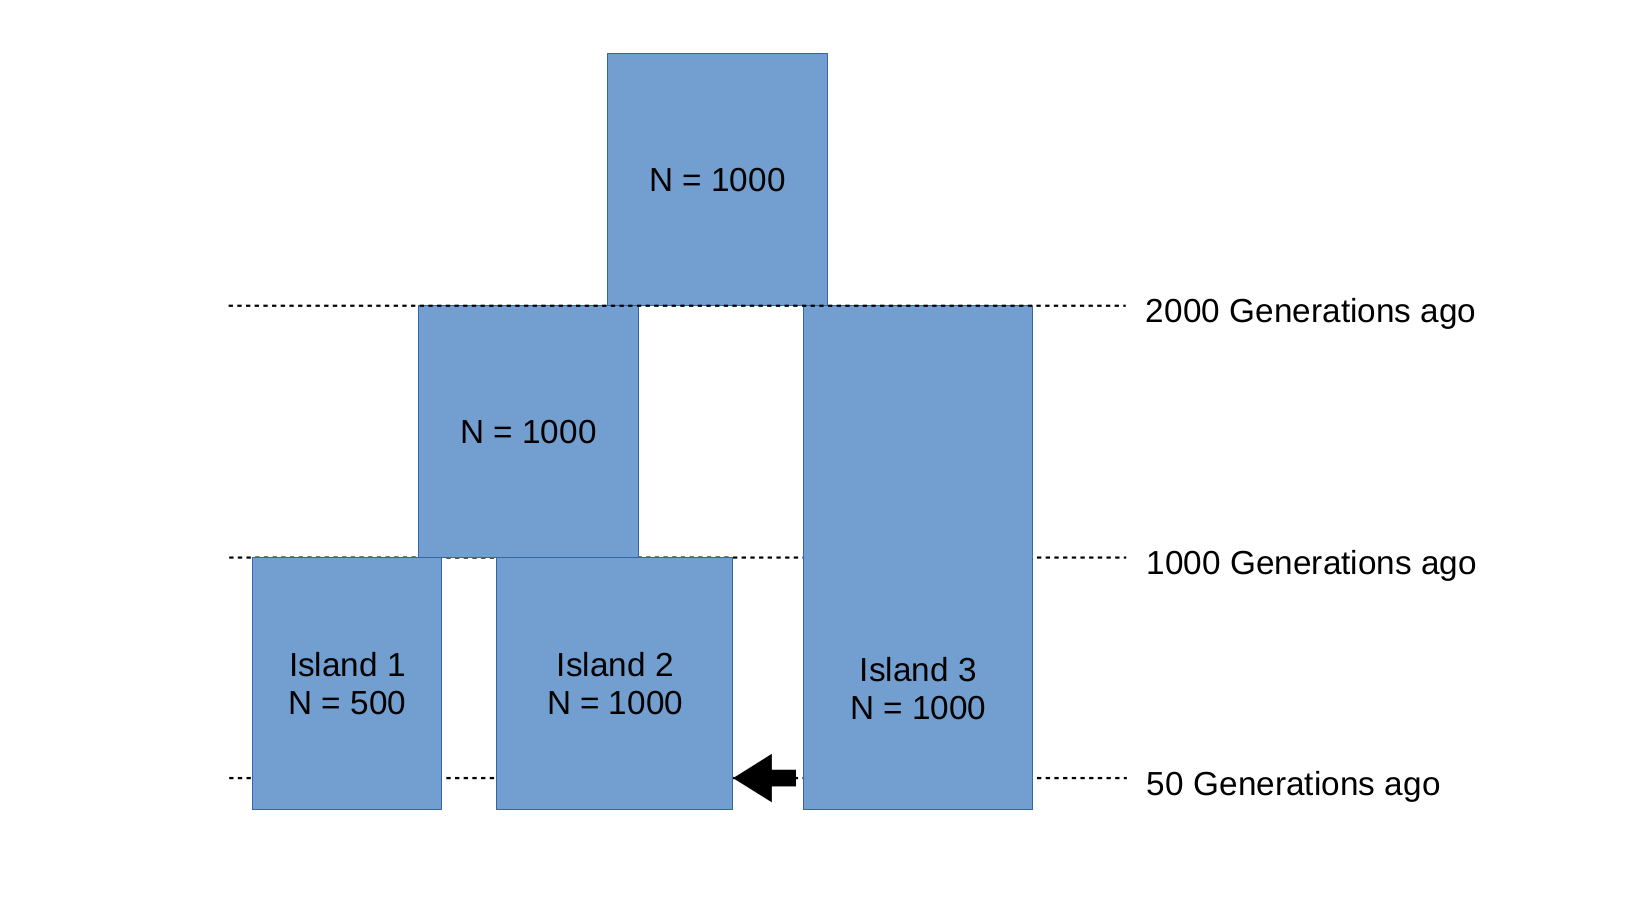

In [57]:
Image(filename="p10_data/tortoise_model.png")

<div class="alert alert-block alert-success">    
    <b>Exercise 8a (5 points):</b>

Based on the demographic history provided, calculate analytically the expected proportion of the genome in modern day tortoises with topology ((island2, island3), island1). Show your working. [5]

</div>

In [ ]:
### ANSWER 8a

<div class="alert alert-block alert-success">    
    <b>Exercise 8b (2 points):</b>
    
Why is this value larger than 10% (the proportion of migrant tortoises on island 2)? [2]

</div>

In [ ]:
### ANSWER 8b

You have been given genomic data for one individual from each island, as well as an outgroup from a related species. Genotypes for all four individuals were called by aligning reads against the tortoise reference genome.

The code below imports the vcf and calcualtes the frequency of the alternate allele for each diploid individual.

In [ ]:
#import genotypes from vcf
vcf_dict = allel.read_vcf('p10_data/tortoise.prac10.vcf.gz', fields=['CHROM', 'calldata/GT'])

#convert to genotypes
genotypes = allel.GenotypeArray(vcf_dict['calldata/GT'])

#get count of alternate allele for each individual
alt_count = genotypes.to_n_alt()

#convert to frequency by dividing by two (diploid individuals)
alt_frequency = alt_count/2

alt_frequency = pd.DataFrame(alt_frequency, columns=["island1", "island2", "island3", "outgroup"])

alt_frequency

The code below extracts the chromosome name for each SNP. You do not need to use the chromosomes dataframe, but it's provided in case you want to subset the data.

In [ ]:
#extract chromosome information
chromosome = pd.DataFrame(vcf_dict['variants/CHROM'], columns=["CHROM"])

chromosome

<div class="alert alert-block alert-success">    
    <b>Exercise 9a (3 points):</b>
    
Assuming the outgroup genotype represents the ancestral state, modify the code below to make a dataframe of polarised allele frequencies. [3]

NOTE: If you are unsure of how to answer this question, just run the first code block provided. You will not be penalised in subsequent questions.    
</div>

In [14]:
#we make a copy of the dataframe that we will modify to compute the derived frequency
#You can always re-run this code block if you make a mistake in the next one
derived_frequency = alt_frequency.copy()

In [ ]:
#identify sites that need to be 'flipped' as a boolean array
sites_to_flip = #ADD YOUR CODE HERE

#the code below will flip the allele frequencies at all sites where sites_to_flip == True
derived_frequency[sites_to_flip] = 1 - derived_frequency[sites_to_flip] 

derived_frequency

<div class="alert alert-block alert-success">
    <b>Exercise 9b (4 points):</b>
    
Using the polarised allele frequencies, estimate the proportion ($f$) of island 2 tortoise genomes made up of introgressed alleles from island 3 tortoises. [4]
    
</div>

In [ ]:
#ANSWER 9b

<div class="alert alert-block alert-success">    
    <b>Question 10a (8 points):</b>
    
Provide two hypotheses that could explain the discrepancy between the estimated admixture proportion and the expected value based on the number of tortoises that were moved between the islands. [Your mark for this question will not depend on whether your answer for the previous question is correct.] [8]
    
</div>

In [ ]:
#ANSWER 10a

<div class="alert alert-block alert-success">
        <b>Question 10b (3 points):</b>

For one of your hypotheses above, explain how genomic data could be used to test the hypothesis. [3]
    
</div>

In [ ]:
#ANSWER 10b